In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 

In [3]:
def load_model_results(file_name):
    file = np.load(file_name)
    predictions = file["predictions"]
    targets = file["targets"][:, 0]
    pred_mean = file["prediction_mean"]
    pred_std = file["prediction_std"]
    resids = targets - pred_mean

    return predictions, pred_mean, pred_std, targets, resids

dtype = "validation"
model1_file = f"../ensembles/seed1_128_0.05_3e-4_0.01/swag_{dtype}_uncertainty.npz"
model2_file = f"../ensembles/seed2_128_0.05_3e-4_0.01/swag_{dtype}_uncertainty.npz"
model3_file = f"../ensembles/seed3_128_0.05_3e-4_0.01/swag_{dtype}_uncertainty.npz"

model1_preds, model1_pred_mean, model1_pred_std, model1_targets, model1_resids = load_model_results(model1_file)
model2_preds, model2_pred_mean, model2_pred_std, model2_targets, model2_resids = load_model_results(model2_file)
model3_preds, model3_pred_mean, model3_pred_std, model3_targets, model3_resids = load_model_results(model3_file)

combined_predictions = np.concatenate([model1_preds, model2_preds, model3_preds], axis=1)
combined_means = np.mean(combined_predictions, axis=1)
combined_stds = np.std(combined_predictions, axis=1)
assert np.array_equal(model1_targets, model2_targets)
assert np.array_equal(model1_targets, model3_targets)
combined_residuals = model1_targets - combined_means
residual_mean = np.mean(combined_residuals)
residual_std = np.std(combined_residuals)

# Visualize $\sigma$ and residuals

In [3]:
bins = np.arange(np.min(combined_residuals), np.max(combined_residuals)+0.02, 0.02)
plt.hist(combined_residuals, bins=bins, 
         edgecolor='k', linewidth=1.0, density=True);
plt.plot(bins, norm.pdf(bins, residual_mean, residual_std), color="r")
plt.xlabel("Residual")
plt.ylabel("Density")

Text(0, 0.5, 'Density')

(0.0, 1.05)

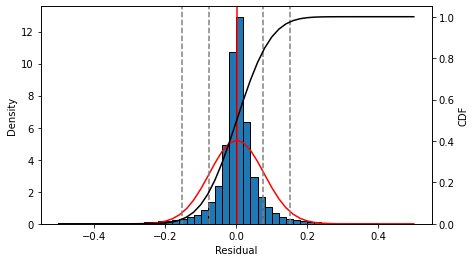

In [4]:
bins = np.arange(-0.5, 0.52, 0.02)
#bins = np.arange(-1.0, 1.02, 0.02)

fix, ax = plt.subplots(1, figsize=(7, 4))
ax.hist(combined_residuals, bins=bins, 
         edgecolor='k', linewidth=1.0, density=True);
ax.plot(bins, norm.pdf(bins, residual_mean, residual_std), color="r")

#plt.plot(np.arange(-0.5, 0.51, 0.005), norm.pdf(np.arange(-0.5, 0.51, 0.005), residual_mean, 0.5*residual_std), color="k")

ax.axvline(residual_std, color='gray', linestyle="--")
ax.axvline(-residual_std, color='gray', linestyle="--")
ax.axvline(2*residual_std, color='gray', linestyle="--")
ax.axvline(-2*residual_std, color='gray', linestyle="--")
ax.axvline(residual_mean, color="r")
ax.set_xlabel("Residual")
ax.set_ylabel("Density")

ax1 = ax.twinx()
ax1.plot(bins, norm.cdf(bins, residual_mean, residual_std), color="k")
ax1.set_ylabel("CDF")
ax1.set_ylim([0, 1.05])

Text(0.5, 0, 'STD')

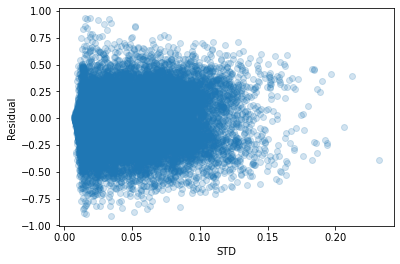

In [5]:
plt.scatter(combined_stds, combined_residuals, alpha=0.2)
plt.ylabel("Residual")
plt.xlabel("STD")

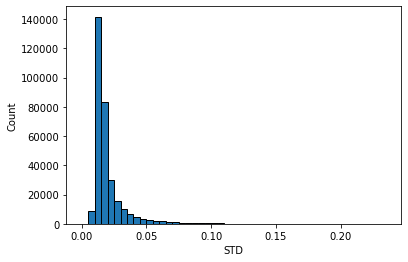

In [6]:
bins = np.arange(0, np.max(combined_stds)+0.005, 0.005)
plt.hist(combined_stds, bins=bins, edgecolor="k");
plt.xlabel("STD");
plt.ylabel("Count");

In [7]:
print(np.min(combined_stds), np.max(combined_stds))

0.00728956825858932 0.23193377454664546


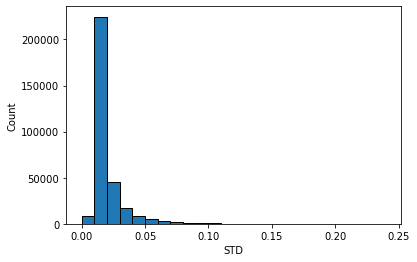

In [8]:
bins = np.arange(0, np.max(combined_stds)+0.01, 0.01)
plt.hist(combined_stds, bins=bins, edgecolor="k");
plt.xlabel("STD");
plt.ylabel("Count");

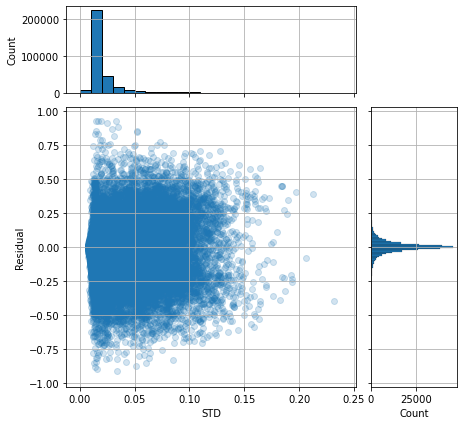

In [9]:
# https://matplotlib.org/stable/gallery/axes_grid1/scatter_hist_locatable_axes.html#sphx-glr-gallery-axes-grid1-scatter-hist-locatable-axes-py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(7, 7))

x = combined_stds 
y = combined_residuals

# the scatter plot:
ax.scatter(x, y, alpha=0.2)

# create new axes on the right and on the top of the current axes
divider = make_axes_locatable(ax)
# below height and pad are in inches
ax_histx = divider.append_axes("top", 1.2, pad=0.2, sharex=ax)
ax_histy = divider.append_axes("right", 1.2, pad=0.2, sharey=ax)

# make some labels invisible
ax_histx.xaxis.set_tick_params(labelbottom=False)
ax_histy.yaxis.set_tick_params(labelleft=False)

# now determine nice limits by hand:
binwidth = 0.01
xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
lim = (int(xymax/binwidth))*binwidth

bins_x = np.arange(0,  np.max(x)+ binwidth, binwidth)
bins_y = np.arange(-np.max(np.abs(y)), np.max(np.abs(y))+ binwidth, binwidth)

ax_histx.hist(x, bins=bins_x, edgecolor="k")
ax_histy.hist(y, bins=bins_y, orientation='horizontal', edgecolor="k", linewidth=0.15)

ax.grid(True)
ax_histx.grid(True)
ax_histy.grid(True)

#ax_histy.set_xticks(np.arange(0, 5201, 2000))
ax_histy.set_xlabel("Count")
ax_histx.set_ylabel("Count")

ax.set_ylabel("Residual")
ax.set_xlabel("STD")
plt.show()

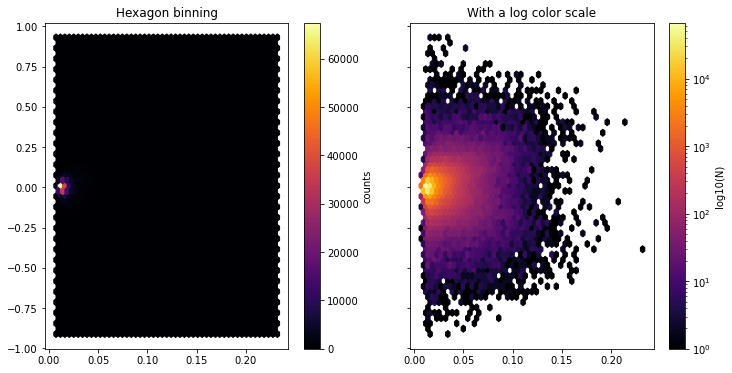

In [10]:
# https://matplotlib.org/stable/gallery/statistics/hexbin_demo.html
fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=True, figsize=(12, 6))

hb = ax0.hexbin(x, y, gridsize=50, cmap='inferno')
# ax0.set(xlim=xlim, ylim=ylim)
ax0.set_title("Hexagon binning")
cb = fig.colorbar(hb, ax=ax0, label='counts')

hb = ax1.hexbin(x, y, gridsize=50, bins='log', cmap='inferno', mincnt=1)
# ax1.set(xlim=xlim, ylim=ylim)
ax1.set_title("With a log color scale")
cb = fig.colorbar(hb, ax=ax1, label='log10(N)')

plt.show()

# Bin $\sigma$

In [11]:
import seaborn as sns

In [12]:
df_data = {"std":combined_stds, "mean":combined_means, "residual":combined_residuals}
df = pd.DataFrame(data=df_data)
df.head()

std      mean  residual
0  0.017737 -0.430377 -0.009623
1  0.011969  0.272362 -0.002362
2  0.013719 -0.295417  0.005417
3  0.012285 -0.038830 -0.041170
4  0.011783  0.193131  0.016869

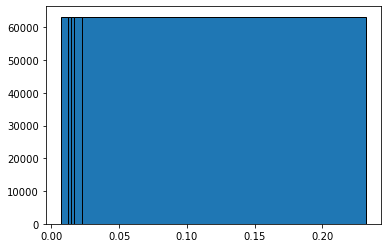

(array([0.00728957, 0.01219602, 0.01419694, 0.01670823, 0.0229343 ,
        0.23193377]),
 array([63293., 63292., 63292., 63292., 63292.]))

In [13]:
n_bins = 5

## https://www.statology.org/equal-frequency-binning-python/
#define function to calculate equal-frequency bins 
def equalObs(x, nbin):
    nlen = len(x)
    return np.interp(np.linspace(0, nlen, nbin + 1),
                     np.arange(nlen),
                     np.sort(x))

#create histogram with equal-frequency bins 
n, bins, patches = plt.hist(df["std"], equalObs(df["std"], n_bins), edgecolor='black')
plt.show()

#display bin boundaries and frequency per bin 
bins, n

In [14]:
df_cats, bins = pd.cut(df["std"], bins=bins, labels=range(n_bins), retbins=True, include_lowest=True)
df["std_cat"] = df_cats.values
df_cats

0         3
1         0
2         1
3         1
4         0
         ..
316456    1
316457    1
316458    3
316459    4
316460    1
Name: std, Length: 316461, dtype: category
Categories (5, int64): [0 < 1 < 2 < 3 < 4]

In [15]:
fig, ax = plt.subplots(1, figsize=(15, 8))
ax.grid(True)
sns.violinplot(y=df["residual"], x=df["std_cat"], ax=ax) #, scale="width")
#plt.xticks(rotation=45);

<AxesSubplot:xlabel='std_cat', ylabel='residual'>

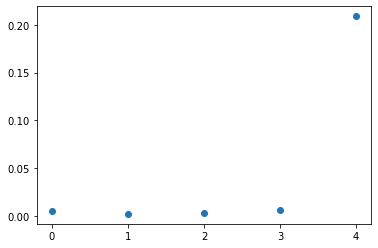

In [16]:
widths = []
for ind in range(len(bins)-1):
    widths.append(bins[ind+1]-bins[ind])
    
plt.scatter(range(n_bins), widths)
plt.xticks(range(n_bins));

# Find $\alpha$ for bins

In [17]:
# Find the percentage of true picks that are within the STD
df.groupby("std_cat").apply(lambda x: (((x["std"]-abs(x.residual)) > 0).sum())/len(x))

std_cat
0    0.465770
1    0.441967
2    0.407729
3    0.350913
4    0.274948
dtype: float64

In [18]:
# Count the number of additional picks needed for 68% of the true picks to be within 1 std
df.groupby("std_cat").apply(lambda x: np.ceil(len(x)*0.68-(((x["std"]-abs(x.residual)) > 0).sum())))

std_cat
0    13560.0
1    15066.0
2    17233.0
3    20829.0
4    25637.0
dtype: float64

In [19]:
# make a column for std/residual => corresponds to how much the std would need to scale to include the true pick
df["std_frac"] = abs(df["residual"])/df["std"]

In [20]:
# grab stds that need to be larger, sort by std_frac, get the rows corresponding to the needed number of additional picks to have 68% of picks 
df_alpha = df.groupby("std_cat").apply(lambda x: (x[x["std_frac"] > 1].sort_values("std_frac")).iloc[int(np.ceil(len(x)*0.68-(x["std_frac"] < 1).sum()))])

In [22]:
alphas = df_alpha["std_frac"].values
alphas

array([1.66901919, 1.83779417, 2.01904533, 2.43106813, 2.82878457])

In [23]:
df.groupby("std_cat").apply(lambda x: (((x["std"]*alphas[x["std_cat"].unique()[0]]-abs(x.residual)) > 0).sum())/len(x))

std_cat
0    0.680012
1    0.680007
2    0.680023
3    0.680007
4    0.680007
dtype: float64

# Accurate Uncertainties for Deep Learning Using Calibrated Regression
1. Compute CDF $F_t$ of $N(\mu_t, \sigma^2_t)$ for t $\in$ [1, T]
2. Evalute $F_t(y_t)$ for t $\in$ [1, T]
3. $F_t(y_t)=p$ for t $\in$ [1, T], compute $\frac{| \{y_t | F_t(y_t) \leq p, t=1...,T \}|}{T}$

In [30]:
df["y_t"] = model1_targets

In [32]:
df

std      mean  residual std_cat  std_frac   y_t
0       0.017737 -0.430377 -0.009623       3  0.542548 -0.44
1       0.011969  0.272362 -0.002362       0  0.197310  0.27
2       0.013719 -0.295417  0.005417       1  0.394866 -0.29
3       0.012285 -0.038830 -0.041170       1  3.351288 -0.08
4       0.011783  0.193131  0.016869       0  1.431645  0.21
...          ...       ...       ...     ...       ...   ...
316456  0.013244 -0.236123 -0.003877       1  0.292761 -0.24
316457  0.013011 -0.393518 -0.096482       1  7.415613 -0.49
316458  0.016900  0.434816  0.035184       3  2.081903  0.47
316459  0.039421  0.311520  0.098480       4  2.498153  0.41
316460  0.013356 -0.432886 -0.017114       1  1.281368 -0.45

[316461 rows x 6 columns]

In [36]:
df["cdf_yt"] = df.apply(lambda x: norm.cdf(x["y_t"], x["mean"], x["std"]), axis=1)

<AxesSubplot:>

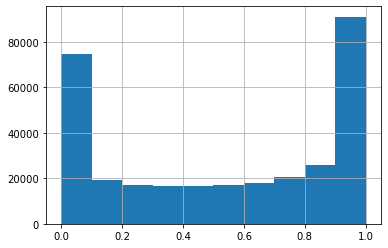

In [39]:
df.cdf_yt.hist()

In [62]:
p_hat = []
T = len(df)
for index, row in df.iterrows():
    p = row["cdf_yt"]
    p_hat.append((df["cdf_yt"] <= p).sum()/T)
df["p_hat"] = p_hat

In [84]:
plt.plot(np.arange(0, 1.01, 0.1), np.arange(0, 1.01, 0.1), color="gray", linestyle="--")
plt.scatter(df.cdf_yt.values, df.p_hat.values, alpha=0.1)
plt.ylabel("Empirical")
plt.xlabel("Predicted")

Text(0.5, 0, 'Predicted')

In [71]:
from sklearn.isotonic import IsotonicRegression

In [133]:
iso_reg = IsotonicRegression().fit(df.p_hat.values, df.cdf_yt.values)

In [134]:
p_hat_cal = []
p_hat_uncal = []
for p in np.arange(0, 1.05, 0.05):
    p_hat_cal.append((df["cdf_yt"] <= iso_reg.predict([p])[0]).sum()/T)
    p_hat_uncal.append((df["cdf_yt"] <= p).sum()/T)

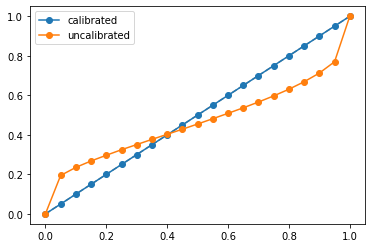

In [135]:
plt.plot(np.arange(0, 1.05, 0.05), np.arange(0, 1.05, 0.05), color="gray", linestyle="--")
plt.plot(np.arange(0, 1.05, 0.05), p_hat_cal, marker="o", label="calibrated")
plt.plot(np.arange(0, 1.05, 0.05), p_hat_uncal, marker="o", label="uncalibrated")
plt.legend()

In [137]:
cal_data = {"uncal":np.arange(0, 1.05, 0.05), "cal":iso_reg.predict(np.arange(0, 1.05, 0.05))}
cal_df = pd.DataFrame(cal_data)
cal_df

uncal       cal
0    0.00       NaN
1    0.05  0.000003
2    0.10  0.001448
3    0.15  0.015808
4    0.20  0.055380
5    0.25  0.121928
6    0.30  0.205787
7    0.35  0.298339
8    0.40  0.394442
9    0.45  0.490665
10   0.50  0.584198
11   0.55  0.673316
12   0.60  0.754495
13   0.65  0.826131
14   0.70  0.886672
15   0.75  0.934939
16   0.80  0.969193
17   0.85  0.989850
18   0.90  0.998558
19   0.95  0.999985
20   1.00  1.000000

- use different datasets for fitting/testing calibration 
- make calbration plot using $\alpha$ values

In [138]:
df.cdf_yt.describe()

count    316461.000000
mean          0.535029
std           0.383613
min           0.000000
25%           0.121929
50%           0.584200
75%           0.934940
max           1.000000
Name: cdf_yt, dtype: float64

# Quantile Regression

In [36]:
from sklearn.linear_model import QuantileRegressor

n_train = 1000
rng = np.random.default_rng(12345)
inds = rng.choice(combined_stds.shape[0], size=n_train, replace=False)
X = combined_stds[inds].reshape(-1, 1)
#X = np.append(X, X**2, axis=1)
y_act = combined_residuals[inds]
out_bounds_predictions = np.zeros_like(inds, dtype=np.bool_)

quantiles = [0.16, 0.84]
#quantiles = [0.05, 0.95]
predictions = {}
models = {}

for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0)
    y_pred = qr.fit(X, y_act).predict(X)
    predictions[quantile] = y_pred
    models[quantile] = qr
    
    if quantile == min(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred >= y_act
    )
    elif quantile == max(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred <= y_act
        )

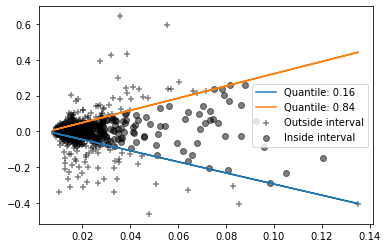

In [38]:
#plt.scatter(X, y_act, color="black", linestyle="dashed", label="True mean")

for quantile, y_pred in predictions.items():
    plt.plot(X, y_pred, label=f"Quantile: {quantile}")
    
plt.scatter(
    X[out_bounds_predictions],
    y_act[out_bounds_predictions],
    color="black",
    marker="+",
    alpha=0.5,
    label="Outside interval",
)
plt.scatter(
    X[~out_bounds_predictions],
    y_act[~out_bounds_predictions],
    color="black",
    alpha=0.5,
    label="Inside interval",
)

plt.legend()

In [49]:
point = np.array([0.02]).reshape(-1, 1)
lb = models[0.16].predict(point)
ub = models[0.84].predict(point)
ub-lb